# COGS 108 - Final Project


# Group Members:

Name, PID, Project Contribution

- Kenny Wibowo - A12030884 - Data Cleaning, Data Parsing
- Varun Sujit - A11886049 - Written Sections and Organization, Data Visualization
- Angela Xu - A12413011 - Data Analysis, Data Visualization
- Aarjav Kothari - A91087718 - Section organization and reserch, Data Analysis
- Joseph Thomas - A12008739 - Data Cleaning, Data Analysis

# Introduction and Background

For many on the internet, it seemed as though 2016 was a particularly awful year due to the deaths of many beloved actors, musician, and other celebrities. However, it may not actually be the case that 2016 had an unusually high number of celebrity deaths. Snopes examined the number of notable deaths reported by various news outlets in 2016 and in previous years and saw that while several news outlets reported more deaths in 2016 than in other years, the differences were not unusually high. This also does not necessarily mean than more celebrities are dying but rather it could be that news outlets are reporting more celebrity deaths in recent years. According to The Guardian, social media has contributed in amplifying emotional response after a celebrity death due to the speed at which news travels on these websites and apps as well as social media bringing people closer to the celebrities they adore. Time Magazine suggests that it is not the number of celebrity deaths that made 2016 unusual but rather the fact that many of the celebrities that passed away were particularly notable, which makes it seem like 2016 was worse than previous years.

The Telegraph also discusses some theories about why so many celebrities seemed to die in 2016. It could be that more people are dying in general or more people are being considered celebrities. It is also possible that many celebrities had unhealthy lifestyles that ultimately contributed to their untimely deaths. People’s perceptions could also have been affected due to celebrities dying on the same day or within days of each other. We also once again get the theory that social media amplifies celebrity deaths.

BBC ran an article regarding the pre-prepared orbituries for their radio and tv shows and saw a huge spike in the trend in the number of orbituries being prepared. BBC seemed to look into the social media aspect and if the numbers matched the spike on the social media trend. BBC created more pre-prepared orbituries in 2016 then they had combined   from 2013-2015.

For our project, we will be examining the social media theory in particular. Since we get news spreads almost instantly through social media platforms and these platforms provide millions of people a place to express their emotions, it is quite plausible that social media has skewed people’s perceptions regarding the number of celebrity deaths.

In other words, our main question is this: What is the total number of significant celebrities that passed away in 2016, compared to other years? How has social media impacted our bias of noting these deaths? We propose that that although it may be true that a significant number of celebrities passed away in 2016, the introduction of modern media, especially through social mediums such as Facebook and Reddit, has caused a sense of “over sensationalization” that biased our judgement of how many celebrities passed away in 2016 compared to other years.

References: 

1) https://www.snopes.com/2016/12/28/2016-the-deadliest-year-for-celebrities/ 

2) http://www.telegraph.co.uk/men/thinking-man/why-are-so-many-celebrities-dying-in-2016/

3) http://www.bbc.com/news/magazine-38329740

# Data Description

For context of this project, we are considering every individual that is present in a category or list in https://en.wikipedia.org/wiki/Lists_of_celebrities as a celebrity. Our data is comprised of lists of celebrities, and their relevence via pytrends, an API that queries google trends (https://trends.google.com/trends/). As a result, we need to parse through every link in the list recursively, and extract the list of celebrities that are deceased. The html parsing is done by using BeautifulSoup. This data will then be stored in a JSON file which can easily be converted into a pandas dataframe for future analysis. The pytrends API, allows users to query google trends with a list of keywords. The popularity of each key word is then compared to the other, returning numerical values in proportion to the other. For example if one keyword has a value 100 and the other 50, this means that the former is twice as popular for that particular day/time. This means in order for our data to proportionally the same across multiple queries, each celebrity must be queried along with a constant keyword, one that has a preferably stable popularity.

## Data Cleaning/Pre-processing

The first step in our project is to import our dependencies

In [1]:
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
from urllib.parse import urlparse
from collections import deque
from pytrends.request import TrendReq
from datetime import datetime
import time
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
import scipy.stats as stats

ModuleNotFoundError: No module named 'pytrends'

In [ ]:
import sys
!{sys.executable} -m pip install pytrends

First, we will define a helper function that we will use to return the celebrity name and death date, along with any other features we would like to extract. 

If we pass in any page that isn't a wikipedia page of a deceased notable celebrity (as per our definition), the function will return `None`.

In [ ]:
def get_death_date(soup):
    table_selector = soup.select('table.infobox.vcard')

    if table_selector:
        table = table_selector[0]
        
        # Important features we would like to handle specially
        name = table.find('span', class_='fn')
        born = table.find('span', class_='bday')
        died = table.find('span', class_='dday deathdate')
        
        # Only return if the person has a name, has born data, and died
        if name and born and died:
            data =  {'Name': name.text, 'Born': born.text, 'Died': died.text}
            
            # Extract other features that we would like to keep.
            rows = table.find_all('tr')
            for row in rows:
                header = row.find('th')
                datum = row.find('td')
                if header and datum and header.text not in data:
                    data[header.text.replace('\xa0', ' ').strip()] = datum.get_text(' ', strip=True)
                    
            return data
        
    return None

Then, we will recursively traverse the links through Breadth First Search and visit all Wikipedia links reachable from the 'List of Celebrities' page. 

In [2]:
# Breadth First Search traversal.

wikipedia_url = 'https://en.wikipedia.org'
starting_endpoint = '/wiki/Lists_of_celebrities'
click_limit = 2

# Dictionary of visited links
# 'url' -> number of clicks taken to get to link
links_visited = {starting_endpoint: 0} 
# Queue of links to visit
links_queue = deque()
links_queue.appendleft(starting_endpoint)

# Create a buffer of dataframes
data_buffer = deque()

# Debug info
num_visited = 0

# Find all links on the page that lead to another wikipedia page.
while links_queue:
    link = links_queue.pop()
    page = requests.get(wikipedia_url + link)
    soup = BeautifulSoup(page.content, 'html.parser')
    num_visited += 1
    
    # Debug info
    if links_visited[link] >= click_limit - 1:
        num_links = len(links_visited)
        num_deads = len(data_buffer)
        percentage = format(100.0*(float(num_visited)/num_links), '.2f')
        print((percentage + "% - " + str(len(links_queue)) + " left, " + str(num_deads) + " recorded.").ljust(60),  end='\r', flush=True)
    else:
        print("Loading initial pages...", end='\r', flush=True)
    
    # See if page is of deceased person - if so, get the data
    results = get_death_date(soup)
    
    # Append to dataframe buffer if we've found a match
    if results:
        data_buffer.append(pd.DataFrame([results]))
    
    # Break early on click limit or if page isn't a list
    if links_visited[link] == click_limit or ("List" not in link and "Category:" not in link):
        continue
    
    content = soup.find('div', id='content')
    
    # Continue BFS on links in the page
    if content:
        for candidate in content.findAll('a'):
            if 'href' in candidate.attrs:
                link_in_page = urlparse(candidate.attrs['href']).path
                                
                # Add to queue if it's a link we haven't seen before.
                if link_in_page not in links_visited and link_in_page.startswith('/wiki/') and 'File' not in link_in_page:
                    links_visited[link_in_page] = links_visited[link] + 1
                    links_queue.appendleft(link_in_page)

# Concatenate all of the buffer into the dataframe that holds our celebrity data
df_celebrities = pd.concat(data_buffer)

NameError: name 'get_death_date' is not defined

Since this takes such a long time, we will run this once and cache it into a JSON file. All subsequent operations will be run off of the loaded JSON file.

In [112]:
with open('celebrities.json', 'w') as file:
    file.write(df_celebrities.to_json(orient='records'))

NameError: name 'df_celebrities' is not defined

Now, we can read the file back in as the JSON in order to circumvent the crawling process for future usage.

In [120]:
df_celebrities = pd.read_json("celebrities.json", orient="records")

In [121]:
date_objects = []

base_date = datetime.strptime("2004-01-01", "%Y-%m-%d")

for date in df_celebrities["Died"]:
    date_objects.append(datetime.strptime(date, "%Y-%m-%d"))
df_celebrities["Died"] = date_objects


df_valid = df_celebrities[df_celebrities["Died"] >= base_date]

Since pytrends records begin in 2004, we will discard any deaths that happened before that. This leaves us with 846 celebrities that died from 2004-01-01 to present.

In [122]:
#Search word to compare it to
comparator = "Grand Canyon"

#Open the pytrends request
pytrends = TrendReq(hl='en-US', tz=360)

#Create a list for the new column in the table
trends = []
comparator_average_trends = []
trend_ratio = []

#Find the relative trend at time of death compared to comparator
#Comparator relative trend value taken from 2004-01-01
def relative_trend(name, died):
    #Enter the name for searching the trend
    kw_list = [comparator, name]
    #Get a dataframe of the relative trends
    e_catcher = 0
    while e_catcher == 0:
        try:
            pytrends.build_payload(kw_list, timeframe='all')
            df_py = pytrends.interest_over_time()
            e_catcher = 1
        except:
            time.sleep(3600)
    cv = df_py[comparator].tolist()
    comparator_avg = sum(cv)/float(len(cv))
    trend = df_py[(df_py.index.month == died.month) & (df_py.index.year == died.year)][name].iloc[0]
    trend_ratio = trend/comparator_avg
    return trend, comparator_avg, trend_ratio
    

#Loop through and find all the trends relative to grand canyon
counter = 0
for name, died in zip(df_valid["Name"], df_valid["Died"]):
    #Check if there are more than two parts to the name
    name_split = name.split(" ")
    name_split_len = len(name_split)
    shortened_name = name_split[0] + " " + name_split[name_split_len-1]
    if  name_split_len > 2:
        long_rt, cvl, trl = relative_trend(name,died)
        short_rt, cvs, trs = relative_trend(shortened_name,died)
        if long_rt > short_rt:
            trends.append(long_rt)
            comparator_average_trends.append(cvl)
            trend_ratio.append(trl)
        else:
            trends.append(short_rt)
            comparator_average_trends.append(cvs)
            trend_ratio.append(trs)
    else:
        trend, cv, tr = relative_trend(name,died)
        trends.append(trend)
        comparator_average_trends.append(cv)
        trend_ratio.append(tr)
    counter += 1
    print(("Celebrity trends parsed = " + str(counter)), end='\r', flush=True)
df_valid['Trends'] = trends
df_valid['Comp_Average'] = comparator_average_trends
df_valid['Trend_Ratio'] = trend_ratio

/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

This code accesses pytrends in order to calculate the trends for each celebrity at time of death, and compares it to the average trend of our designated comparator. We chose Grand Canyon as our comparator as a decently popular search term, that would help minimize the innacuracy that stems from the fact that the trend values bottom out and zero and have a max of 100. These boundaries introduce a chance of error. We also used Grand Canyon because we wanted a relative trend, so by comparing each celebrity to the Grand Canyon we have a baseline that every celebrity is compared to. We compared the trend of the celebrity at time of death with the average of the relative trend of the Grand Canyon. We ended up keeping three values, the trend of the Celebrity, the average trend of the Grand Canyon relative to that celebrity, and the ratio between the two.
<br><br>
In order to give the most accurate trend of the celebrity, we also accounted for the fact that celebrities may be searched in different ways, so in the case of celebrities having more than a 2 part name, we searched for both the entire name, and then the first and last name, and returned the value that had the higher trends.
<br><br>
We also ran into issues with the Google API, since there was a fetch request limit of around 350 an hour. To counter this, we caught the exception when it appeared and then put the thread to sleep for an hour, then tried again.

In [123]:
with open('valid.json', 'w') as file:
    file.write(df_valid.to_json(orient='records'))

# Data Analysis/Data Visualization

In [11]:
df_valid = pd.read_json("valid.json", orient="records")

In [12]:
df_valid["Died"] = pd.to_datetime(df_valid['Died'], unit="ms")
#Get rid of 2018, since its not a complete year
df_valid = df_valid[df_valid["Died"] < datetime.strptime("2018-01-01", "%Y-%m-%d")]

We also removed deaths in 2018 since it was not a complete year.

In [6]:
#Count the number of deaths per year
deaths_per_year = defaultdict(int)
for row in df_valid["Died"]:
    deaths_per_year[row.year] += 1
deaths_sorted = OrderedDict(sorted(deaths_per_year.items()))

In [7]:
#Print number of deaths per year sorted by deaths
for key,value in deaths_sorted.items():
    print( "Deaths in " + str(key) + " = " + str(value))

Deaths in 2004 = 56
Deaths in 2005 = 48
Deaths in 2006 = 56
Deaths in 2007 = 48
Deaths in 2008 = 58
Deaths in 2009 = 45
Deaths in 2010 = 62
Deaths in 2011 = 61
Deaths in 2012 = 58
Deaths in 2013 = 61
Deaths in 2014 = 60
Deaths in 2015 = 63
Deaths in 2016 = 78
Deaths in 2017 = 77


Here we see that 2016 was the year with the most celebrity deaths, as we saw mentioned in the article that was in our preliminary research. We also see that 2017 was right behind it.

In [8]:
#Find the trends per year
trends_per_year = defaultdict(list)
for key,value in deaths_per_year.items():
    df = df_valid[(df_valid.Died >= datetime.strptime(str(key), "%Y")) & (df_valid.Died < datetime.strptime(str(key + 1), "%Y"))]
    trends_per_year[key] = df.Trends.tolist()

In [9]:
#Find the average of trends per year
trends_per_year_avg = defaultdict(float)

for key,value in trends_per_year.items():
    tr = trends_per_year[key]
    trends_per_year_avg[key] = sum(tr)/ float(len(tr))

In [10]:
trends_per_year_avg_ord = OrderedDict(sorted(trends_per_year_avg.items()))

In [12]:
for key,value in trends_per_year_avg_ord.items():
    print( "Trend avg in " + str(key) + " = " + str(value))

Trend avg in 2004 = 14.071428571428571
Trend avg in 2005 = 11.479166666666666
Trend avg in 2006 = 6.696428571428571
Trend avg in 2007 = 5.875
Trend avg in 2008 = 12.293103448275861
Trend avg in 2009 = 16.4
Trend avg in 2010 = 17.387096774193548
Trend avg in 2011 = 14.180327868852459
Trend avg in 2012 = 24.56896551724138
Trend avg in 2013 = 10.852459016393443
Trend avg in 2014 = 20.283333333333335
Trend avg in 2015 = 16.6984126984127
Trend avg in 2016 = 20.307692307692307
Trend avg in 2017 = 17.31168831168831


Here we can see that even though we hypothesized that trends would go up inherently because of the prevalence of technology and the spread of information, there doesn't seem to be a correlation between time and trends average.

In [13]:
for key,value in trends_per_year_avg_ord.items():
    print( "Deaths and Trend average in " + str(key) + " = " + str(deaths_per_year[key]) + ", " + str(trends_per_year_avg[key]))

Deaths, Trend sum, Trend average in 2004 = 56, 788, 14.071428571428571
Deaths, Trend sum, Trend average in 2005 = 48, 551, 11.479166666666666
Deaths, Trend sum, Trend average in 2006 = 56, 375, 6.696428571428571
Deaths, Trend sum, Trend average in 2007 = 48, 282, 5.875
Deaths, Trend sum, Trend average in 2008 = 58, 713, 12.293103448275861
Deaths, Trend sum, Trend average in 2009 = 45, 738, 16.4
Deaths, Trend sum, Trend average in 2010 = 62, 1078, 17.387096774193548
Deaths, Trend sum, Trend average in 2011 = 61, 865, 14.180327868852459
Deaths, Trend sum, Trend average in 2012 = 58, 1425, 24.56896551724138
Deaths, Trend sum, Trend average in 2013 = 61, 662, 10.852459016393443
Deaths, Trend sum, Trend average in 2014 = 60, 1217, 20.283333333333335
Deaths, Trend sum, Trend average in 2015 = 63, 1052, 16.6984126984127
Deaths, Trend sum, Trend average in 2016 = 78, 1584, 20.307692307692307
Deaths, Trend sum, Trend average in 2017 = 77, 1333, 17.31168831168831


We can begin to see here that there doesn't seem to be a correlation between the number of deaths per year and the trend averages. Or at least a not very strong one. A year with 60 deaths in 2014 had a higher trend average than the 77 deaths in 2017. We also see that the highest trend average was not in 2016, but in 2012.

In [14]:
#Count the number of positive trend deaths per year
positive_deaths_per_year = defaultdict(int)
for death,trend in zip(df_valid["Died"],df_valid["Trends"]):
    if trend >= 1:
        positive_deaths_per_year[death.year] += 1
positive_deaths_sorted = OrderedDict(sorted(positive_deaths_per_year.items()))

In [15]:
for key,value in positive_deaths_sorted.items():
    print( "Trend Ratios in " + str(key) + " greater than 1 = " + str(value))

Trend Ratios in 2004 greater than 1 = 38
Trend Ratios in 2005 greater than 1 = 39
Trend Ratios in 2006 greater than 1 = 36
Trend Ratios in 2007 greater than 1 = 35
Trend Ratios in 2008 greater than 1 = 42
Trend Ratios in 2009 greater than 1 = 31
Trend Ratios in 2010 greater than 1 = 43
Trend Ratios in 2011 greater than 1 = 46
Trend Ratios in 2012 greater than 1 = 50
Trend Ratios in 2013 greater than 1 = 42
Trend Ratios in 2014 greater than 1 = 38
Trend Ratios in 2015 greater than 1 = 41
Trend Ratios in 2016 greater than 1 = 57
Trend Ratios in 2017 greater than 1 = 57


With this statistic, we checked each year the number of deaths that were significantly high in trend. We checked this by seeing if the trend ratio was at least one, and counted all the deaths that met this condition.

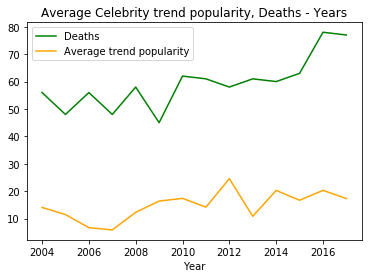

In [21]:
years = list(deaths_sorted.keys())
deaths = list(deaths_sorted.values())
trend_data = list(trends_per_year_avg_ord.values())

plt.plot(years, deaths, color='g', label='Deaths')
plt.plot(years, trend_data, color='orange', label='Average trend popularity')
plt.title('Average Celebrity trend popularity, Deaths - Years')
plt.xlabel('Year')
plt.legend()
plt.show()

In this graph, plotting a line graph for deaths over the years and a line graph for trend ratio average over the years, we see that there doesnt seem to be much correlation between the two statistics.

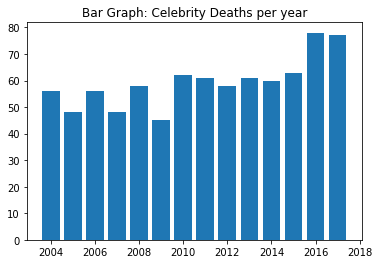

In [17]:
plt.bar(years,deaths)
plt.title('Bar Graph: Celebrity Deaths per year')
plt.show()

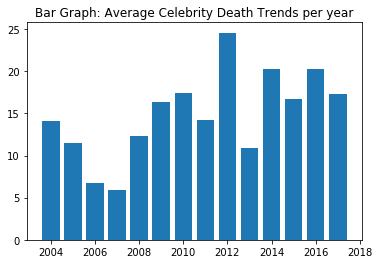

In [18]:
plt.bar(years,trend_data)
plt.title('Bar Graph: Average Celebrity Death Trends per year')
plt.show()

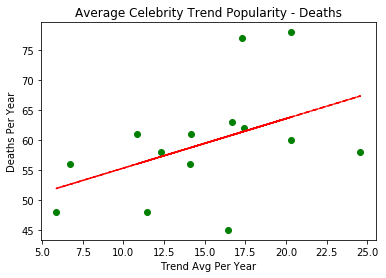

In [19]:
plt.scatter(trend_data, deaths, color='g')
z = np.polyfit(trend_data, deaths, 1)
p = np.poly1d(z)
plt.plot(trend_data,p(trend_data),"r--")
plt.title('Average Celebrity Trend Popularity - Deaths')
plt.xlabel('Trend Avg Per Year')
plt.ylabel('Deaths Per Year')
plt.show()

Here we see that even though there is a positive correlation between the trend average per year, and the deaths per year, there is a high variation of the scatter points around the trend line.

In [64]:
dictionary = {'trends': trend_data, 'deaths': deaths}
regressionframe = pd.DataFrame(data=dictionary)
outcome_1, predictors_1 = patsy.dmatrices('deaths ~ trends', regressionframe)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 deaths   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     3.111
Date:                Wed, 21 Mar 2018   Prob (F-statistic):              0.103
Time:                        20:18:00   Log-Likelihood:                -49.263
No. Observations:                  14   AIC:                             102.5
Df Residuals:                      12   BIC:                             103.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.0512      7.364      6.389      0.0

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


Here our initial impressions of the data are proved. We see that the correlation between the two statistics to be pretty minor, with an R-squared value of 0.206, showing us that there is indeed a weak positive correlation.

---
To further examine why people might have felt that 2016 was a particularly bad year for celebrity deaths, we will be looking at cause of death data, as well as the ages at which these celebrities died, and seeing if there are any abnormalities. If 2016 was an abnormal year in these aspects, that could help explain the feeling that many had that 2016 was a bad year.

First, we will take a look at celebrity ages at death. If perhaps there was an unusually large number of untimely/young deaths among celebrities in 2016, that may have affected people's perceptions.

We can obtain the ages by finding the difference in time between the birth dates and death dates.

In [ ]:
# Function to calculate age at time of death
def calc_age(x):
    return np.floor((x.days)/365)

# Copy data frame and keep relevant columns
df_cod = df_valid.copy()
df_cod = df_cod[["Born","Died","Cause of death"]]
df_cod["Born"] = pd.to_datetime(df_cod["Born"])
# Calculate age at death and save to new column
df_cod["Age at death"] = (df_cod["Died"] - df_cod["Born"]).apply(calc_age)
# Get year of death from date of death and save to new column
df_cod["Death year"] = df_cod["Died"].dt.year

We can then create a pivot table and calculate the average age at death for each year from 2004 to 2017.

In [13]:
# Create pivot table with mean age at death by year
pv1 = pd.pivot_table(df_cod, values="Age at death", index="Death year")
pv1

,Age at death
Death year,
2004,75.125000
2005,77.500000
2006,79.660714
2007,78.937500
2008,78.241379
2009,78.955556
2010,75.419355
2011,74.098361
2012,80.206897


We can then plot these values over time. From the graph below, we can see that we do have a younger average death age in 2016 compared to the last few years prior, but it is not the youngest average death age overall.

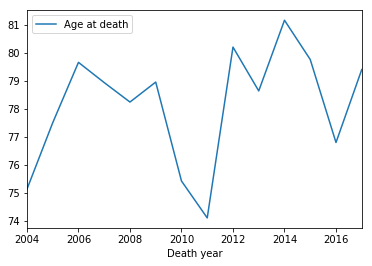

In [14]:
# Visualizing mean age at death by year
df1 = pd.DataFrame(pv1.to_records())
df1 = df1.set_index("Death year")
df1.plot()
plt.show()

Next, we will take a look at the causes of death. Here, we are looking for unusually large amounts of "unnatural deaths" (i.e. deaths that were caused by forces outside of the person's body). Likewise with the age at death, if there were many instances of sudden and unforseen deaths in 2016, it may have skewed people's perceptions.

First, we filter the data and remove entries in which the cause of death is a null value.

In [15]:
# Copy data frame and drop rows containing null values
df_cod2 = df_cod.copy()
df_cod2 = df_cod2.dropna()

In [ ]:
# View unique causes of death
df_cod2["Cause of death"].unique()

As seen in the cell above, the data in the "Cause of death" column is quite messy. In order to clean it up, we write a function to standardize the causes of death and consolidate the similar ones.

In [16]:
# Function to clean up cause of death data/aggregate similar causes
def standardize_cod(cod_in):
    cod_in = cod_in.lower()
    cod_in = cod_in.strip()
    
    cod_in = cod_in.replace("[1]", "")
    cod_in = cod_in.replace("]", "")
    cod_in = cod_in.replace("ailment", "disease")
    
    if "suicide" in cod_in:
        cod_in = "suicide"
    if "murder" in cod_in or "assassin" in cod_in:
        cod_in = "murder"
    if "accident" in cod_in or "collision" in cod_in or "fall" in cod_in or "struck" in cod_in:
        cod_in = "accident"
    if "drug" in cod_in or "alcohol" in cod_in:
        cod_in = "substance abuse"
    if "surgery" in cod_in or "ectomy" in cod_in:
        cod_in = "complications from surgery"
    if "unknown" in cod_in:
        cod_in = "unknown"
        
    if "cancer" in cod_in or "leukemia" in cod_in or "leukaemia" in cod_in or "oma" in cod_in or "polycythemia vera" in cod_in or "myelodysplastic syndrome" in cod_in:
        cod_in = "cancer"
    if "pneumonia" in cod_in:
        cod_in = "pneumonia"
    if "stroke" in cod_in:
        cod_in = "stroke"
    if "heart attack" in cod_in:
        cod_in = "heart attack"
    if "failure" in cod_in or "insufficiency" in cod_in:
        cod_in = "organ failure"
    if "alzheimer" in cod_in:
        cod_in = "alzheimer's"
    if "aneurysm" in cod_in:
        cod_in = "aneurysm"
    if "diabetes" in cod_in:
        cod_in = "diabetes"
    if "dementia" in cod_in:
        cod_in = "dementia"
    if "sepsis" in cod_in or "septic" in cod_in:
        cod_in = "sepsis"
    if "vascul" in cod_in:
        cod_in = "vascular disease"
    if "heart disease" in cod_in or "pulmonary disease" in cod_in or "cardiovascular disease" in cod_in:
        cod_in = "heart disease"
    if "pulmonary edema" in cod_in or "pulmonary fibrosis" in cod_in or "emphysema" in cod_in or "chest infection" in cod_in:
        cod_in = "lung disease"
    if "neuron" in cod_in or "amyotrophic lateral sclerosis" in cod_in or "neuron" in cod_in:
        cod_in = "nervous system disease"
    if "asphyxiation" in cod_in or "strangulation" in cod_in:
        cod_in = "asphyxiation"
    if "embolism" in cod_in or "clot" in cod_in:
        cod_in = "embolism"
    if "hemorrhage" in cod_in or "haemorrhage" in cod_in:
        cod_in = "hemorrhage"
    
    cod_in = cod_in.lower()
    cod_in = cod_in.strip()
    
    return cod_in

In [17]:
# Apply standardizing function to "Cause of death" column
df_cod2["Cause of death"] = df_cod2["Cause of death"].apply(standardize_cod)
df_cod2["Cause of death"].value_counts()

cancer                        76
organ failure                 28
heart attack                  23
pneumonia                     18
stroke                        11
suicide                        8
lung disease                   7
alzheimer's                    7
heart disease                  6
accident                       6
vascular disease               4
cardiac arrest                 4
substance abuse                4
embolism                       3
diabetes                       3
sepsis                         3
dementia                       2
nervous system disease         2
aneurysm                       2
complications from surgery     2
asphyxiation                   2
murder                         2
hemorrhage                     2
kidney disease                 1
unknown                        1
dengue fever                   1
polymyalgia rheumatica         1
sudden death                   1
gunshot wounds                 1
cerebral hypoxia               1
Name: Caus

After cleaning up the data, we get much fewer unique causes of death and we can now group by year and cause.

In [18]:
# Group data by death year and cause of death
grouped = df_cod2.groupby(["Death year", "Cause of death"])
grouped.size()

Death year  Cause of death            
2004        cancer                        3
            heart attack                  1
            heart disease                 1
            murder                        1
            organ failure                 2
            pneumonia                     2
            sepsis                        1
            stroke                        2
            vascular disease              1
2005        asphyxiation                  1
            cancer                        3
            complications from surgery    1
            heart attack                  1
            lung disease                  3
            organ failure                 3
            substance abuse               1
2006        cancer                        4
            heart attack                  1
            organ failure                 2
            pneumonia                     2
            stroke                        2
2007        accident                 

In a first attempt to visualize the cause of death data, the resulting plot is difficult to read because there are still so many different causes of death. Further refining cause of death categories is needed.

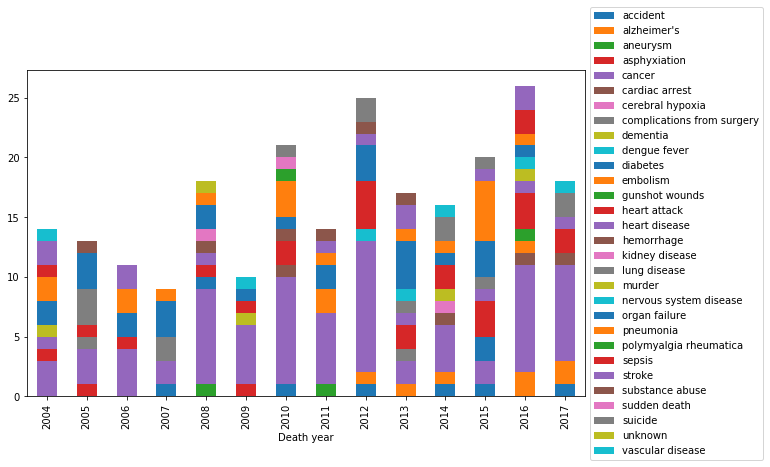

In [19]:
# Visualizing causes of death by year
# This is hard to read because there are so many different causes of death, but left here for reference
grouped.size().unstack().fillna(0).plot(kind="bar", stacked=True, figsize=(10,6)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We write another function to further classify each cause of death as either natural, unnatural, or unknown.

In [20]:
# Function further simplifying cause of death
# Following definition of "unnatural death" as seen on wiki page: https://en.wikipedia.org/wiki/Unnatural_death
def classify_natural(cod_in):
    if cod_in == "unknown" or cod_in == "sudden death":
        return "unknown"
    elif cod_in in ["accident", "asphyxiation", "complications from surgery", "gunshot wounds", "murder", "substance abuse", "suicide"]:
        return "unnatural death"
    else:
        return "natural death"

In [21]:
# Copy data frame and apply function
df_cod3 = df_cod2.copy()
df_cod3["Cause of death"] = df_cod3["Cause of death"].apply(classify_natural)
df_cod3

,Born,Died,Cause of death,Age at death,Death year
0,1974-07-25,2011-05-10,natural death,36.0,2011
2,1947-05-14,2006-10-02,natural death,59.0,2006
4,1963-08-09,2012-02-11,unnatural death,48.0,2012
8,1972-01-13,2017-05-09,natural death,45.0,2017
9,1941-06-22,2006-11-09,natural death,65.0,2006
11,1936-09-27,2012-02-01,unnatural death,75.0,2012
13,1955-09-29,2016-11-14,natural death,61.0,2016
28,1922-05-13,2009-04-25,natural death,87.0,2009
30,1945-11-27,2013-12-31,unnatural death,68.0,2013
34,1915-12-22,2010-10-16,natural death,94.0,2010


After refining the causes of death, we group by year and type once more and plot the data. Looking at the plot below, we see that the number of unnatural deaths in 2016 is not unusual compared to other years.

In [22]:
# Group data by death year and cause of death
grouped2 = df_cod3.groupby(["Death year", "Cause of death"])
grouped2.size()

Death year  Cause of death 
2004        natural death      13
            unnatural death     1
2005        natural death      10
            unnatural death     3
2006        natural death      11
2007        natural death       8
            unnatural death     1
2008        natural death      17
            unknown             1
2009        natural death       9
            unnatural death     1
2010        natural death      18
            unknown             1
            unnatural death     2
2011        natural death      13
            unnatural death     1
2012        natural death      21
            unnatural death     4
2013        natural death      15
            unnatural death     2
2014        natural death      13
            unnatural death     3
2015        natural death      18
            unnatural death     2
2016        natural death      24
            unnatural death     2
2017        natural death      15
            unnatural death     3
dtype: int64

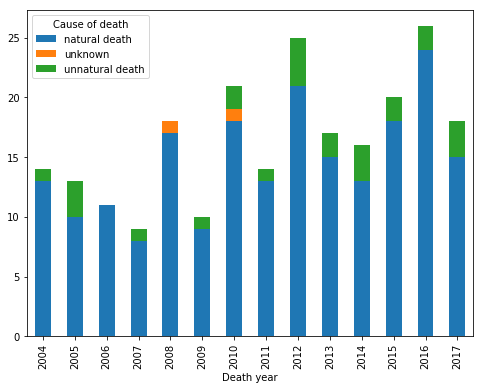

In [23]:
# Plot causes of death by year
grouped2.size().unstack().plot(kind="bar", stacked=True, figsize=(8,6))
plt.show()

Through analysis of death data, it appears that 2016 was not that unusual compared to other years in terms of the age at which celebrities passed away and the causes of death. 

# Privacy/Ethics Considerations

We have permission to utilize these datasets as most of our data is from open sourced websites and are open to public use. Due to celebrities being public figures, it is unlikely that we would encounter any additional privacy issues due the data being dependent on social media trends and their deaths. Because we are allowing wikipedia to define our definition of a celebrity, It is possible that what constitutes a “celebrity” might vary from person to person. This can potentially cause our data to become more confusing as some of the deaths contributing to the dataset might not lead to substantial social media trends compared to other deaths. This could skew that data in that the deaths in a year were notable, but not well-known to American media and public.

# Conclusions and Discussion

From our data analyisis we found that there was a positive weak correlation between social media trends and deaths. The year 2016 had a larger number of popular celebrity deaths and a larger overall number of celebrity deaths from 2004 onwards. This leads us to believe that our initial hypothesis was incorrect and that the wide usage of social media and the internet was not the reason for believing that 2016 had more celebrity deaths than in the past. This contributes to the possiblity that perhaps social media and the internet can aid in public awareness of noteworthy statistical occurences.

As a way to further pursue this topic, analysis could be also be applied in separate regions throughout 2016 to determine internet popularity rather than globally. This could lead to more nuance in the number of celebrity deaths with positive social media trends. The large number of celebrity deaths in 2016 could possibly be because of the number of popular figures born 60 to 80 years ago, in which lifespans coincide with the digital age today, further analysis would also look at birth years as well, to determine if there is a notable trend.